In [89]:
from preprocessing import BCIDataProcessor
import mne
import numpy as np
import matplotlib.pyplot as plt

In [90]:
recording_path = '../recordings/recording_ssvep4_gel.raw.fif'
window_size = 2
window_overlap = 1
nfft1 = 500
nfft2 = 500
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
processor1 = BCIDataProcessor(recording_path, l_freq=10, h_freq=12, window_size=window_size,
                              window_overlap=window_overlap)
processor2 = BCIDataProcessor(recording_path, l_freq=14, h_freq=16, window_size=window_size,
                              window_overlap=window_overlap)
processor3 = BCIDataProcessor(recording_path, l_freq=18, h_freq=20, window_size=window_size,
                              window_overlap=window_overlap)
processor4 = BCIDataProcessor(recording_path, l_freq=22, h_freq=24, window_size=window_size,
                              window_overlap=window_overlap)
processor5 = BCIDataProcessor(recording_path, l_freq=19, h_freq=21, window_size=window_size,
                              window_overlap=window_overlap)
data_arrays = processor.process(psds=True, nfft=nfft1, channels=(5, 6, 7))
data_arrays1 = processor1.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays2 = processor2.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays3 = processor3.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays4 = processor4.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
data_arrays5 = processor5.process(psds=True, nfft=nfft2, channels=(5, 6, 7))
arr_all = [
    #data_arrays,
    data_arrays1,
    data_arrays2,
    data_arrays3,
    data_arrays4,
    data_arrays5
]

In [91]:
# Merge data arrays along feature axis
feature_arrays = {}
for label in data_arrays.keys():
    feature_arrays[label] = np.concatenate([arr[label] for arr in arr_all], axis=2)
feature_arrays['15.0'].shape  # (samples, channels, features)

(45, 3, 25)

In [92]:
# Create X and y based on the labels
X = np.concatenate(list(feature_arrays.values()), axis=0)  # (samples, channels, features)
y = np.concatenate([[label] * feature_arrays[label].shape[0] for label in feature_arrays.keys()])  # (samples,)
# Reshape X to 2D (samples, features)
X = X.reshape(X.shape[0], -1)  # (samples, channels * features)
# Check the shape of X and y
print("X shape:", X.shape)  # (samples, channels * features)

X shape: (180, 75)


Best Parameters: {'svc__C': 0.005, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Classification Report:
               precision    recall  f1-score   support

        11.0       0.60      0.82      0.69        45
        15.0       0.60      0.56      0.57        45
        19.0       0.74      0.51      0.61        45
        23.0       0.56      0.56      0.56        45

    accuracy                           0.61       180
   macro avg       0.62      0.61      0.61       180
weighted avg       0.62      0.61      0.61       180



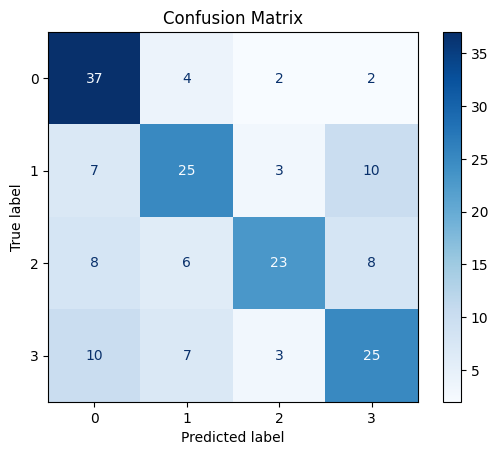

In [93]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assume X and y are already defined
# It's essential to scale features for SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

# Hyperparameter grid
param_grid = {
    'svc__C': [0.005, 0.01, 0.05, 0.1, 1],
    'svc__kernel': ['linear'],
    'svc__gamma': ['scale', 'auto']
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)
best_model = grid_search.best_estimator_

# Cross-validated predictions
y_pred = cross_val_predict(best_model, X, y, cv=cv)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y, y_pred))

# Confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()